(likelihood-ratio-process)=
# 错误模型

除了Anaconda中包含的库之外，本讲座还需要以下库：

In [1]:
!pip install numpyro jax

## 概述

这是{doc}`这个 quantecon 讲座 <likelihood_bayes>`的续篇。

我们将讨论创建复合彩票的两种方式及其后果。

复合彩票可以说是创建了一个_混合分布_。

我们构建复合彩票的两种方式在**时间安排**上有所不同。

* 其中一种方式是在时间开始时一次性在两个可能的概率分布之间进行混合

* 另一种方式是在每个时期都在相同的两个可能的概率分布之间进行混合

这个统计设定与那个 quantecon 讲座中研究的问题相近但不完全相同。

在那个讲座中，有两个独立同分布的过程可能支配着一个非负随机变量 $W$ 的连续抽取。

自然界一劳永逸地决定是从分布 $f$ 还是从分布 $g$ 中进行一系列独立同分布的抽取。

该讲座研究了一个同时知道$f$和$g$但不知道自然在$-1$时刻选择了哪个分布的代理人。

代理人通过假设自然以概率$\pi_{-1}$选择概率分布$f$的方式来表示这种无知，就像抛一枚不公平的硬币。

这个假设使得代理人能够构建一个关于随机序列$\{W_t\}_{t=0}^\infty$的主观联合概率分布。

我们研究了代理人如何使用条件概率法则和观察到的历史数据$w^t =\{w_s\}_{t=0}^t$来形成

$$
\pi_t = E [ \textrm{自然选择分布}  f | w^t] , \quad  t = 0, 1, 2, \ldots
$$

然而，在本讲座的设定中，这个规则赋予了代理人一个错误的模型。

原因是现在工资序列实际上是由一个不同的统计模型描述的。

因此，我们需要对{doc}`quantecon讲座<likelihood_bayes>`的规范进行如下修改。

现在，在**每个时期** $t \geq 0$，自然界抛出一个可能不公平的硬币，其正面（$f$）概率为 $\alpha$，反面（$g$）概率为 $1-\alpha$。

因此，自然界持续地从具有以下c.d.f.的**混合分布**中抽取：

$$
H(w ) = \alpha F(w) + (1-\alpha) G(w), \quad \alpha \in (0,1)
$$

我们将研究两个试图了解工资过程的代理人，他们使用不同的统计模型。

两种类型的代理人都知道 $f$ 和 $g$，但都不知道 $\alpha$。

我们的第一类代理人错误地认为在时间 $-1$ 时，自然界一次性选择了 $f$ 或 $g$，此后永久地从该分布中抽取。

我们的第二类代理人正确地知道，自然界在每个时期都以混合概率 $\alpha \in (0,1)$ 混合 $f$ 和 $g$，尽管代理人不知道混合参数。

我们的第一类代理人应用了在{doc}`这个quantecon讲座 <likelihood_bayes>`中描述的学习算法。

在那节课中统计模型的背景下,这是一个很好的学习算法,它使贝叶斯学习者最终能够学习到自然在时间$-1$时所抽取的分布。

这是因为该代理的统计模型在与数据生成过程一致的意义上是*正确的*。

但在当前情况下,我们的第一类决策者的模型是错误的,因为实际生成数据的模型$h$既不是$f$也不是$g$,因此超出了代理认为可能的模型支持范围。

尽管如此,我们将看到我们的第一类代理仍然能够摸索前进,并最终学到一些有趣且有用的东西,即使这些并不是*真实的*。

相反,事实证明我们这个配备了错误统计模型的第一类代理,最终会学习到$f$或$g$中在特定意义上与实际生成数据的$h$*最接近*的那个概率分布。

我们将说明它在什么意义上最接近。

我们的第二类代理理解自然在每个时期以固定的混合概率 $\alpha$ 在 $f$ 和 $g$ 之间进行混合。

但是代理不知道 $\alpha$。

代理决定使用贝叶斯定律应用于他的模型来学习 $\alpha$。

他的模型是正确的，因为它包含了实际的数据生成过程 $h$ 作为一个可能的分布。

在本讲中，我们将学习

* 自然如何在两个分布 $f$ 和 $g$ 之间*混合*来创建一个新的分布 $h$。

* Kullback-Leibler统计散度 <https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence>，它在不正确的统计模型下控制统计学习

* 一个有用的Python函数 `numpy.searchsorted`，它与均匀随机数生成器一起使用可以从任意分布中进行采样

像往常一样，我们先导入一些Python工具。

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import vectorize, jit
from math import gamma
import pandas as pd
import scipy.stats as sp
from scipy.integrate import quad

import seaborn as sns
colors = sns.color_palette()

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import jax.numpy as jnp
from jax import random

np.random.seed(142857)

@jit
def set_seed():
    np.random.seed(142857)
set_seed()

让我们用Python生成两个贝塔分布

In [3]:
# 两个贝塔分布的参数
F_a, F_b = 1, 1
G_a, G_b = 3, 1.2

@vectorize
def p(x, a, b):
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * x** (a-1) * (1 - x) ** (b-1)

# 两个密度函数
f = jit(lambda x: p(x, F_a, F_b))
g = jit(lambda x: p(x, G_a, G_b))

In [4]:
@jit
def simulate(a, b, T=50, N=500):
    '''
    生成N组T个似然比观测值，
    以N x T矩阵形式返回。

    '''

    l_arr = np.empty((N, T))

    for i in range(N):

        for j in range(T):
            w = np.random.beta(a, b)
            l_arr[i, j] = f(w) / g(w)

    return l_arr

我们还将使用以下Python代码来准备一些信息丰富的模拟

In [5]:
l_arr_g = simulate(G_a, G_b, N=50000)
l_seq_g = np.cumprod(l_arr_g, axis=1)

In [6]:
l_arr_f = simulate(F_a, F_b, N=50000)
l_seq_f = np.cumprod(l_arr_f, axis=1)

## 从复合彩票 $H$ 中抽样

我们实现两种方法从混合模型 $\alpha F + (1-\alpha) G$ 中抽取样本。

我们将使用这两种方法生成样本，并验证它们是否匹配良好。

以下是从复合彩票中抽样的"方法1"的伪代码：

* 第一步：

  * 使用 numpy.random.choice 函数抛一个不公平的硬币，以概率 $\alpha$ 选择分布 $F$，以概率 $1-\alpha$ 选择分布 $G$

* 第二步：

  * 根据硬币抛掷的结果，从 $F$ 或 $G$ 中抽样

* 第三步：

  * 将前两步放在一个大循环中，对 $w$ 的每个实现都执行这些步骤

我们的第二种方法使用均匀分布和以下在 quantecon 讲座 <https://python.quantecon.org/prob_matrix.html> 中描述和使用的事实：

* 如果随机变量 $X$ 的累积分布函数为 $F(X)$，那么随机变量 $F^{-1}(U)$ 也具有累积分布函数 $F(x)$，其中 $U$ 是 $[0,1]$ 上的均匀随机变量。

换句话说，如果 $X \sim F(x)$，我们可以通过从区间 $[0,1]$ 上的均匀分布中抽取随机样本，并计算 $F^{-1}(U)$ 来从 $F$ 中生成随机样本。

我们将结合 `numpy.searchsorted` 命令使用这个事实来直接从 $H$ 中采样。

参见 <https://numpy.org/doc/stable/reference/generated/numpy.searchsorted.html> 了解 `searchsorted` 函数。

查看[Mr. P Solver关于蒙特卡洛模拟的视频](https://www.google.com/search?q=Mr.+P+Solver+video+on+Monte+Carlo+simulation&oq=Mr.+P+Solver+video+on+Monte+Carlo+simulation)，了解这个强大技巧的其他应用。

在下面的Python代码中，我们将使用这两种方法，并确认它们都能很好地从我们的目标混合分布中进行采样。

In [7]:
@jit
def draw_lottery(p, N):
    "直接从复合彩票中抽取。"

    draws = []
    for i in range(0, N):
        if np.random.rand()<=p:
            draws.append(np.random.beta(F_a, F_b))
        else:
            draws.append(np.random.beta(G_a, G_b))

    return np.array(draws)

def draw_lottery_MC(p, N):
    "使用蒙特卡洛技巧从复合彩票中抽取。"

    xs = np.linspace(1e-8,1-(1e-8),10000)
    CDF = p*sp.beta.cdf(xs, F_a, F_b) + (1-p)*sp.beta.cdf(xs, G_a, G_b)

    Us = np.random.rand(N)
    draws = xs[np.searchsorted(CDF[:-1], Us)]
    return draws

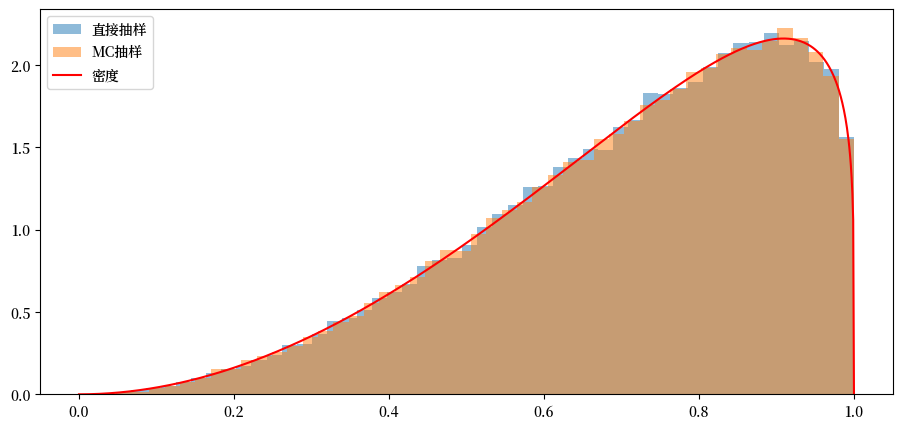

In [8]:
# 验证
N = 100000
α = 0.0

sample1 = draw_lottery(α, N)
sample2 = draw_lottery_MC(α, N)

# 绘制抽样和密度函数
plt.hist(sample1, 50, density=True, alpha=0.5, label='直接抽样')
plt.hist(sample2, 50, density=True, alpha=0.5, label='MC抽样')

xs = np.linspace(0,1,1000)
plt.plot(xs, α*f(xs)+(1-α)*g(xs), color='red', label='密度')

plt.legend()
plt.show()

In [9]:
# %%timeit    # 比较速度
# sample1 = draw_lottery(α, N=int(1e6))

In [10]:
# %%timeit
# sample2 = draw_lottery_MC(α, N=int(1e6))

**注意：** 使用numba加速后，当我们生成1,000,000个样本时，第一种方法实际上只比第二种方法稍慢一点。

## 类型1代理

我们现在来研究类型1代理学到了什么

请记住，我们的类型1代理使用了错误的统计模型，认为自然在时间-1时就一次性地在$f$和$g$之间做出了选择。

因此，类型1代理使用了在{doc}`这个quantecon讲座<likelihood_bayes>`中研究的学习算法。

我们现在简要回顾一下该学习算法。

让$\pi_t$表示贝叶斯后验概率，定义为

$$
\pi_t = {\rm Prob}(q=f|w^t)
$$

似然比过程在控制后验概率$\pi_t$演化的公式中起着主要作用，这是**贝叶斯法则**的一个实例。

贝叶斯法则意味着$\{\pi_t\}$遵循以下递归

$$
\pi_t=\frac{\pi_{t-1} l_t(w_t)}{\pi_{t-1} l_t(w_t)+1-\pi_{t-1}}
$$ (equation-eq-recur1)

其中$\pi_{0}$是$q = f$的贝叶斯先验概率，

即，基于我们尚未看到任何数据而对 $ q $ 的个人或主观信念。

下面我们定义一个Python函数，使用似然比 $ \ell $ 根据递归公式 {eq}`equation-eq-recur1` 来更新信念 $ \pi $

In [11]:
@jit
def update(π, l):
    "使用似然l更新π"

    # 更新信念
    π = π * l / (π * l + 1 - π)

    return π

公式 {eq}`equation-eq-recur1` 可以通过迭代推广,从而得到时间 $ t $ 的后验概率 $ \pi_{t+1} $ 作为时间 $ 0 $ 的先验概率 $ \pi_0 $ 和时间 $ t $ 的似然比过程 $ L(w^{t+1}) $ 的函数表达式。

首先,注意更新规则

$$
\pi_{t+1}
=\frac{\pi_{t}\ell \left(w_{t+1}\right)}
{\pi_{t}\ell \left(w_{t+1}\right)+\left(1-\pi_{t}\right)}
$$

意味着

$$
\begin{aligned}
\frac{1}{\pi_{t+1}}
    &=\frac{\pi_{t}\ell \left(w_{t+1}\right)
        +\left(1-\pi_{t}\right)}{\pi_{t}\ell \left(w_{t+1}\right)} \\
    &=1-\frac{1}{\ell \left(w_{t+1}\right)}
        +\frac{1}{\ell \left(w_{t+1}\right)}\frac{1}{\pi_{t}}.
\end{aligned}
$$

$$
\Rightarrow
\frac{1}{\pi_{t+1}}-1
=\frac{1}{\ell \left(w_{t+1}\right)}\left(\frac{1}{\pi_{t}}-1\right).
$$

因此

$$
\begin{aligned}
    \frac{1}{\pi_{t+1}}-1
    =\frac{1}{\prod_{i=1}^{t+1}\ell \left(w_{i}\right)}
        \left(\frac{1}{\pi_{0}}-1\right)

=\frac{1}{L\left(w^{t+1}\right)}\left(\frac{1}{\pi_{0}}-1\right).
\end{aligned}
$$

由于 $ \pi_{0}\in\left(0,1\right) $ 且
$ L\left(w^{t+1}\right)>0 $，我们可以验证
$ \pi_{t+1}\in\left(0,1\right) $。

通过重新整理前面的方程，我们可以将 $ \pi_{t+1} $ 表示为
$ L\left(w^{t+1}\right) $（即t+1时刻的似然比过程）
和初始先验 $ \pi_{0} $ 的函数

$$
\pi_{t+1}=\frac{\pi_{0}L\left(w^{t+1}\right)}{\pi_{0}L\left(w^{t+1}\right)+1-\pi_{0}}.
$$ (equation-eq-bayeslaw103)

公式{eq}`equation-eq-bayeslaw103`是公式{eq}`equation-eq-recur1`的推广。

公式{eq}`equation-eq-bayeslaw103`可以被视为在观察到数据批次$ \left\{ w_{i}\right\} _{i=1}^{t+1} $后，对先验概率$ \pi_0 $的一步修正。

## 当混合分布$H$生成数据时，类型1代理学到什么

我们现在研究当混合分布$h;\alpha$真实地每期生成数据时会发生什么。

次鞅或上鞅继续描述 $\pi_t$

它显露出其丑陋的一面，导致 $\pi_t$ 要么收敛到 $0$，要么收敛到 $1$。

即使在实际中自然总是在 $f$ 和 $g$ 之间混合，这一点仍然成立。

在验证了关于 $\pi_t$ 序列可能极限点的这一说法之后，我们将深入研究决定 $\pi_t$ 极限值的基本力量。

让我们设定一个 $\alpha$ 值，然后观察 $\pi_t$ 如何演变。

In [12]:
def simulate_mixed(α, T=50, N=500):
    """
    当真实密度为混合h;α时，生成N组T个似然比观测值，
    返回N x T矩阵
    """

    w_s = draw_lottery(α, N*T).reshape(N, T)
    l_arr = f(w_s) / g(w_s)

    return l_arr

def plot_π_seq(α, π1=0.2, π2=0.8, T=200):
    """
    当混合分布支配数据时，计算并绘制π_seq和对数似然比过程
    """

    l_arr_mixed = simulate_mixed(α, T=T, N=50)
    l_seq_mixed = np.cumprod(l_arr_mixed, axis=1)

    T = l_arr_mixed.shape[1]
    π_seq_mixed = np.empty((2, T+1))
    π_seq_mixed[:, 0] = π1, π2

    for t in range(T):
        for i in range(2):
            π_seq_mixed[i, t+1] = update(π_seq_mixed[i, t], l_arr_mixed[0, t])

    # 绘图
    fig, ax1 = plt.subplots()
    for i in range(2):
        ax1.plot(range(T+1), π_seq_mixed[i, :], label=rf"$\pi_0$={π_seq_mixed[i, 0]}")

    ax1.plot(np.nan, np.nan,  '--', color='b', label='对数似然比过程')
    ax1.set_ylabel("$\pi_t$")
    ax1.set_xlabel("t")
    ax1.legend()
    ax1.set_title("当 $\\alpha G + (1-\\alpha)$ F 支配数据时")

    ax2 = ax1.twinx()
    ax2.plot(range(1, T+1), np.log(l_seq_mixed[0, :]), '--', color='b')
    ax2.set_ylabel("$log(L(w^{t}))$")

    plt.show()

<>:34: SyntaxWarning: invalid escape sequence '\p'
<>:34: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_7315/940956931.py:34: SyntaxWarning: invalid escape sequence '\p'
  ax1.set_ylabel("$\pi_t$")


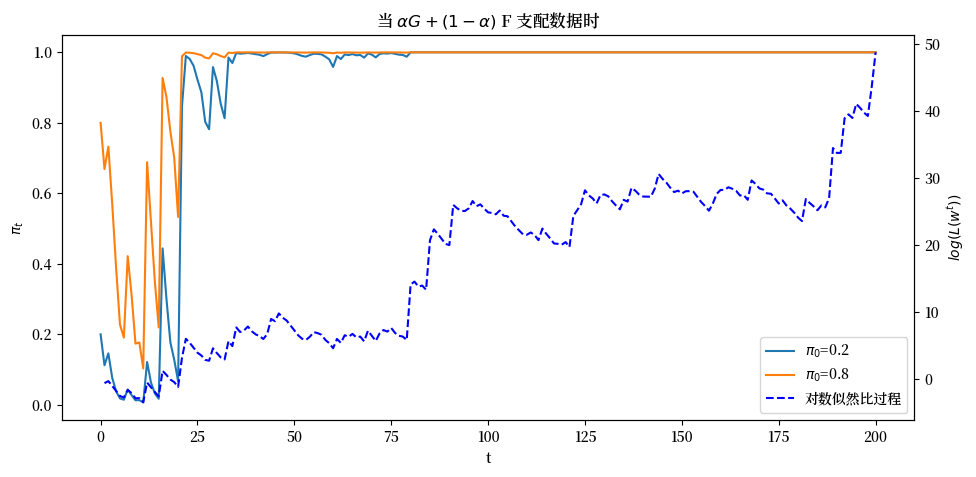

In [13]:
plot_π_seq(α = 0.6)

上图显示了对数似然比过程的一个样本路径（蓝色虚线），以及从两个不同初始条件开始的 $\pi_t$ 的样本路径。

让我们看看当我们改变 $\alpha$ 时会发生什么

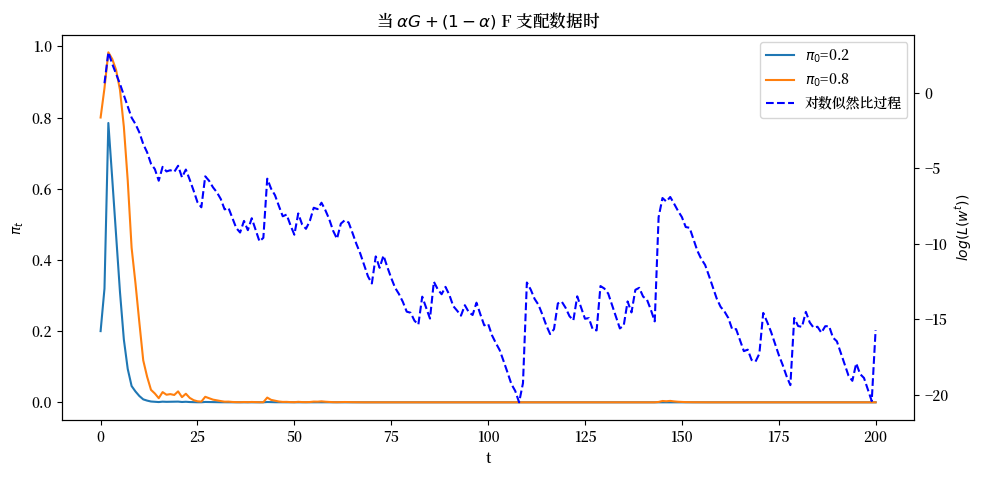

In [14]:
plot_π_seq(α = 0.2)

显然，$\alpha$ 对 $\pi_t$ 在 $t \rightarrow + \infty$ 时的终点有很大影响

## Kullback-Leibler 散度决定 $\pi_t$ 的极限

为了理解是什么决定了 $\pi_t$ 的极限点是 $0$ 还是 $1$，以及答案如何依赖于生成以下混合分布的真实混合概率 $\alpha \in (0,1)$：

$$ h(w) \equiv h(w | \alpha) = \alpha f(w) + (1-\alpha) g(w) $$

我们将计算以下两个 Kullback-Leibler 散度：

$$
KL_g (\alpha) = \int \log\left(\frac{g(w)}{h(w)}\right) h(w) d w
$$

和

$$
KL_f (\alpha) = \int \log\left(\frac{f(w)}{h(w)}\right) h(w) d w
$$

我们将绘制这两个函数关于 $\alpha$ 的图像，同时用 $\alpha$ 来改变 $h(w) = h(w|\alpha)$。

$\pi_t$ 的极限由下式决定：

$$ \min_{f,g} \{KL_g, KL_f\} $$

唯一可能的极限是 $0$ 和 $1$。

当 $t \rightarrow +\infty$ 时，$\pi_t$ 趋向于 1 当且仅当 $KL_f < KL_g$

In [15]:
@vectorize
def KL_g(α):
    "Compute the KL divergence between g and h."
    err = 1e-8                          # to avoid 0 at end points
    ws = np.linspace(err, 1-err, 10000)
    gs, fs = g(ws), f(ws)
    hs = α*fs + (1-α)*gs
    return np.sum(np.log(gs/hs)*hs)/10000

@vectorize
def KL_f(α):
    "Compute the KL divergence between f and h."
    err = 1e-8                          # to avoid 0 at end points
    ws = np.linspace(err, 1-err, 10000)
    gs, fs = g(ws), f(ws)
    hs = α*fs + (1-α)*gs
    return np.sum(np.log(fs/hs)*hs)/10000


# compute KL using quad in Scipy
def KL_g_quad(α):
    "Compute the KL divergence between g and h using scipy.integrate."
    h = lambda x: α*f(x) + (1-α)*g(x)
    return quad(lambda x: np.log(g(x)/h(x))*h(x), 0, 1)[0]

def KL_f_quad(α):
    "Compute the KL divergence between f and h using scipy.integrate."
    h = lambda x: α*f(x) + (1-α)*g(x)
    return quad(lambda x: np.log(f(x)/h(x))*h(x), 0, 1)[0]

# vectorize
KL_g_quad_v = np.vectorize(KL_g_quad)
KL_f_quad_v = np.vectorize(KL_f_quad)


# Let us find the limit point
def π_lim(α, T=5000, π_0=0.4):
    "Find limit of π sequence."
    π_seq = np.zeros(T+1)
    π_seq[0] = π_0
    l_arr = simulate_mixed(α, T, N=1)[0]

    for t in range(T):
        π_seq[t+1] = update(π_seq[t], l_arr[t])
    return π_seq[-1]

π_lim_v = np.vectorize(π_lim)

让我们首先绘制每个$\alpha$对应的KL散度$KL_g\left(\alpha\right), KL_f\left(\alpha\right)$。

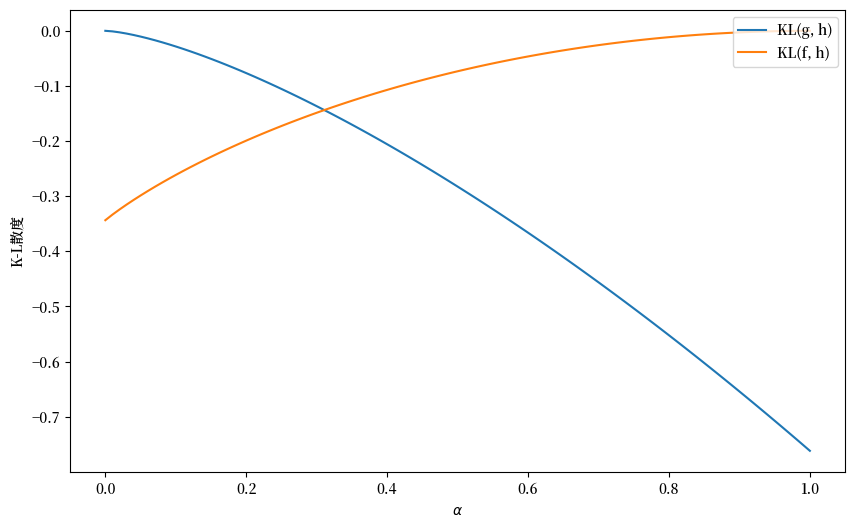

In [16]:
α_arr = np.linspace(0, 1, 100)
KL_g_arr = KL_g(α_arr)
KL_f_arr = KL_f(α_arr)

fig, ax = plt.subplots(1, figsize=[10, 6])

ax.plot(α_arr, KL_g_arr, label='KL(g, h)')
ax.plot(α_arr, KL_f_arr, label='KL(f, h)')
ax.set_ylabel('K-L散度')
ax.set_xlabel(r'$\alpha$')

ax.legend(loc='upper right')
plt.show()

In [17]:
# # 使用Scipy计算KL散度

# α_arr = np.linspace(0, 1, 100)
# KL_g_arr = KL_g_quad_v(α_arr)
# KL_f_arr = KL_f_quad_v(α_arr)

# fig, ax = plt.subplots(1, figsize=[10, 6])

# ax.plot(α_arr, KL_g_arr, label='KL(g, h)')
# ax.plot(α_arr, KL_f_arr, label='KL(f, h)')
# ax.set_ylabel('K-L散度')

# ax.legend(loc='upper right')
# plt.show()

让我们计算一个 $\alpha$ 值，使得 $h$ 和 $g$ 之间的 KL 散度等于 $h$ 和 $f$ 之间的 KL 散度。

In [18]:
# 当 KL_f = KL_g 时
α_arr[np.argmin(np.abs(KL_g_arr-KL_f_arr))]

0.31313131313131315

我们可以计算并绘制每个 $\alpha$ 的收敛点 $\pi_{\infty}$ 来验证收敛确实受KL散度支配。

蓝色圆圈显示了模拟发现的不同 $\alpha$ 值（记录在 $x$ 轴上）对应的 $\pi_t$ 的极限值。

因此，下图证实了最小KL散度如何支配我们的类型1代理最终学到的内容。

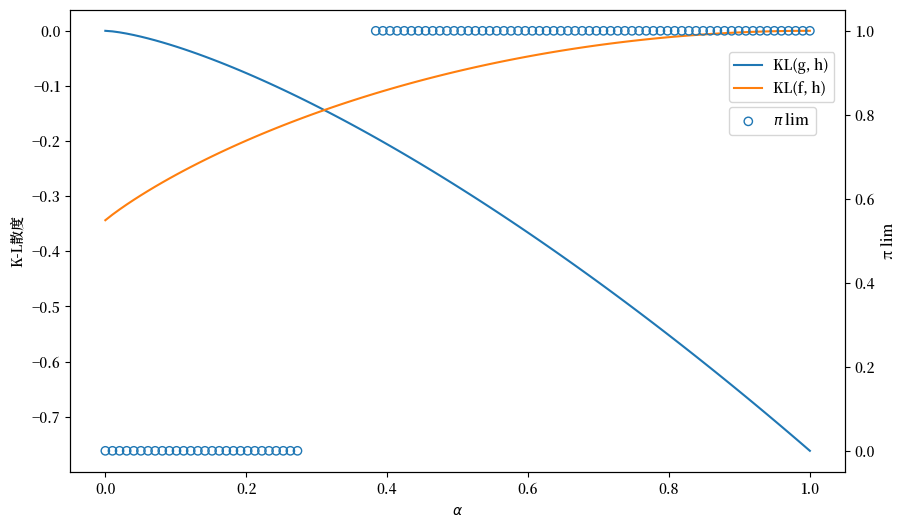

In [19]:
α_arr_x = α_arr[(α_arr<0.28)|(α_arr>0.38)]
π_lim_arr = π_lim_v(α_arr_x)

# plot
fig, ax = plt.subplots(1, figsize=[10, 6])

ax.plot(α_arr, KL_g_arr, label='KL(g, h)')
ax.plot(α_arr, KL_f_arr, label='KL(f, h)')
ax.set_ylabel('K-L散度')
ax.set_xlabel(r'$\alpha$')

# plot KL
ax2 = ax.twinx()
# plot limit point
ax2.scatter(α_arr_x, π_lim_arr, facecolors='none', edgecolors='tab:blue', label=r'$\pi$ lim')
ax2.set_ylabel('π lim')

ax.legend(loc=[0.85, 0.8])
ax2.legend(loc=[0.85, 0.73])
plt.show()

显然，我们的类型1学习者在对其错误设定的统计模型集应用贝叶斯法则时，最终会学习到一个尽可能接近真实模型的近似模型，这种接近程度是通过Kullback-Leibler散度来衡量的。

## 类型2代理

现在我们来描述类型2代理如何构建他的学习问题以及他最终学到什么。

我们的类型2代理理解正确的统计模型，但承认他不知道$\alpha$。

我们应用贝叶斯法则来推导学习$\alpha$的算法，假设代理知道

$$
h(w) = h(w| \alpha)
$$

但不知道$\alpha$。

我们假设此人以先验概率$\pi_0(\alpha)$开始，其中$\alpha \in (0,1)$，这个先验具有我们在{doc}`这个quantecon讲座<bayes_nonconj>`中使用的形式之一。

我们将启动`numpyro`并将其应用于当前情况。

贝叶斯法则现在采取以下形式：

$$
\pi_{t+1}(\alpha) = \frac {h(w_{t+1} | \alpha) \pi_t(\alpha)}

{ \int h(w_{t+1} | \hat \alpha) \pi_t(\hat \alpha) d \hat \alpha }
$$

我们将使用numpyro来近似这个方程。

我们将创建后验分布$\pi_t(\alpha)$的图形，展示当$t \rightarrow +\infty$时的变化，这与quantecon讲座<https://python.quantecon.org/bayes_nonconj.html>中展示的图形相对应。

我们预计，当$t \rightarrow + \infty$时，后验分布将会收敛到真实的$\alpha$值周围。

让我们先尝试使用均匀先验分布。

我们使用Numpyro中的`Mixture`类来构建似然函数。

In [20]:
α = 0.8

# 使用真实α值模拟数据
data = draw_lottery(α, 1000)
sizes = [5, 20, 50, 200, 1000, 25000]

def model(w):
    α = numpyro.sample('α', dist.Uniform(low=0.0, high=1.0))

    y_samp = numpyro.sample('w',
        dist.Mixture(dist.Categorical(jnp.array([α, 1-α])), [dist.Beta(F_a, F_b), dist.Beta(G_a, G_b)]), obs=w)

def MCMC_run(ws):
    "使用MCMC计算观测到ws时的后验分布"

    kernal = NUTS(model)
    mcmc = MCMC(kernal, num_samples=5000, num_warmup=1000, progress_bar=False)

    mcmc.run(rng_key=random.PRNGKey(142857), w=jnp.array(ws))
    sample = mcmc.get_samples()
    return sample['α']

以下代码生成了下面的图表，显示了不同历史长度下$\alpha$的贝叶斯后验分布。

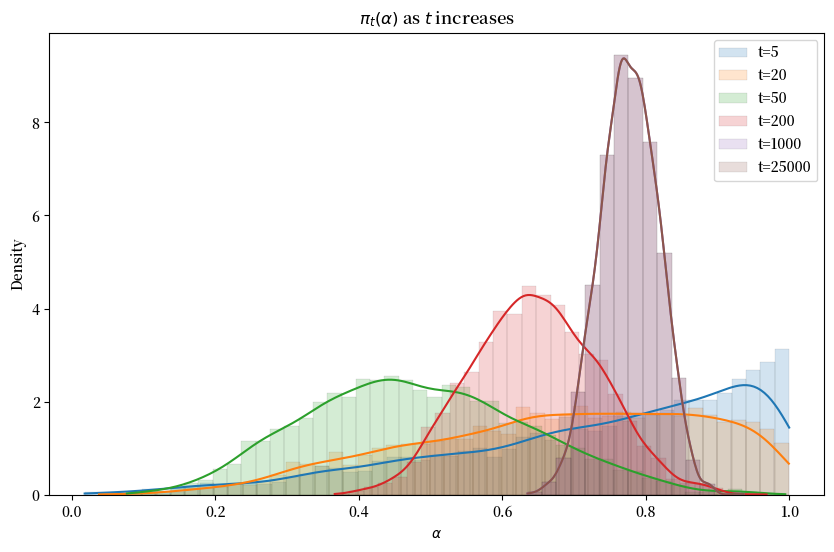

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(sizes)):
    sample = MCMC_run(data[:sizes[i]])
    sns.histplot(
        data=sample, kde=True, stat='density', alpha=0.2, ax=ax,
        color=colors[i], binwidth=0.02, linewidth=0.05, label=f't={sizes[i]}'
    )
ax.set_title(r'$\pi_t(\alpha)$ as $t$ increases')
ax.legend()
ax.set_xlabel(r'$\alpha$')
plt.show()

显然，随着观测历史长度的增加，贝叶斯后验会逐渐收敛到混合参数的真实值 $\alpha = .8$。

## 总结说明

我们的类型1个体使用了一个错误的统计模型。

他认为要么是 $f$ 要么是 $g$ 生成了 $w$ 过程，只是不知道具体是哪一个。

这是错误的，因为实际上自然在每个周期都以混合概率 $\alpha$ 进行混合。

我们的类型1个体最终会相信要么是 $f$ 要么是 $g$ 生成了 $w$ 序列，具体结果取决于相对于 $h$ 具有较小KL散度的模型（$f$ 或 $g$）。

我们的类型2个体有一个不同的统计模型，这个模型是正确设定的。

他知道统计模型的参数形式，但不知道混合参数 $\alpha$。

他知道自己不知道这个参数。

但通过结合贝叶斯定律、统计模型和历史数据，他最终能够对$\alpha$做出越来越准确的推断。

这个小实验展示了一些重要的普遍原理，这些原理支配着贝叶斯学习错误设定模型的结果。

因此，在实证研究中普遍存在以下情况。

科学家用统计模型流形$S$来处理数据，其中$s(X|\theta)$是随机向量$X$上的概率分布，$\theta \in \Theta$是参数向量，而$\Theta$索引了模型流形。

科学家将观测数据解释为随机向量$X$的实现值$x$，想要解决一个**逆问题**，即某种方式_求逆_$s(x|\theta)$以从$x$推断$\theta$。

但科学家的模型是错误设定的，它只是自然用来生成$X$的未知模型$h$的一个近似。


如果科学家使用贝叶斯定律或相关的基于似然的方法来推断$\theta$，通常在大样本量的情况下，这个逆问题会推断出一个使科学家模型$s$相对于自然模型$h$的KL散度最小化的$\theta$值。